Tech Deal Forge - ML Model Training (Optimized v2.4)

Upload your deals CSV file:


Saving ml_training_data_20251208_180238.csv to ml_training_data_20251208_180238 (1).csv
Uploaded: ml_training_data_20251208_180238 (1).csv

 Dataset Info:
Total deals: 83,402
Columns: 17
Date range: 2025-09-22T22:45:41.806670 to 2025-12-08T18:02:31.905965
Unique links: 5,907
   ✓ Removed 3559 deals without prices
Encoded 2 websites
   ✓ Encoded 67 categories into 5 groups
   ✓ Created temporal features (reduced to avoid overfitting)
Created price features + price percentile
Computing historical features (time-aware, no leakage)...
Historical features created (log-scaled times_seen)
Deals with history: 74,277 (93.0%) 
Created interaction features

Computing rebalanced target variable...
Target score range: 6.9 - 99.9
Mean score: 50.5
Std dev: 7.7
Rebalanced weights: discount=40, price=30, reliability=20, recency=10

Optimized feature engineering complete!
   - Features: 24
   - Training samples: 79,843
   - Removed invalid: 0

Splitting data...
   - Training set: 63,874 deals
   - Test 

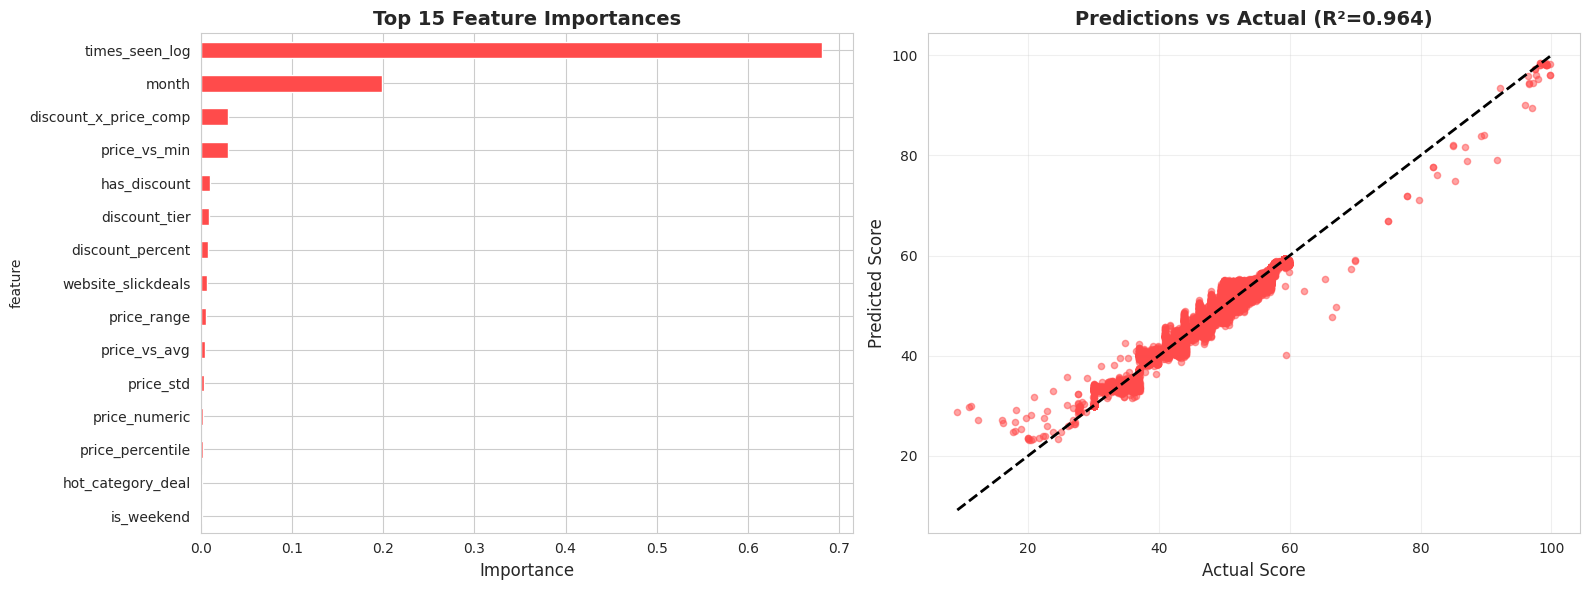


Sample Predictions (first 10 test cases):
   Actual  Predicted    Error  Error %
48.655921  49.108119 0.452198 0.929380
48.604619  49.092994 0.488375 1.004792
59.302834  59.218410 0.084424 0.142361
56.274961  54.673602 1.601359 2.845598
58.020227  58.199140 0.178913 0.308363
36.931472  37.088866 0.157394 0.426179
51.073888  49.635443 1.438444 2.816398
54.979532  54.763461 0.216071 0.393003
49.459101  49.472910 0.013808 0.027919
59.165044  59.212625 0.047581 0.080420

   Average absolute error: 0.88 points (1.7% of mean score)

Model saved: deal_predictor_optimized_20251209_055917.joblib

Model Summary:
   - Algorithm: Random Forest Regressor
   - Features: 24
   - Training samples: 63,874
   - R² Score: 0.964
   - RMSE: 1.48 points
   - MAE: 0.88 points


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


TRAINING is complete


Dashboard of my Features:
1. price_numeric
2. discount_percent
3. has_discount
4. discount_tier
5. price_bucket
6. price_percentile
7. website_bestbuy
8. website_slickdeals
9. website_newegg
10. category_gaming
11. category_laptop
12. category_monitor
13. category_electronics
14. category_computer_parts
15. month
16. is_weekend
17. price_vs_avg
18. price_vs_min
19. times_seen_log
20. price_std
21. price_range
22. recent_trend
23. discount_x_price_comp
24. hot_category_deal


In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Sets the style for the figures for my feature importance chart.
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


print("\nUpload your deals CSV file:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"Uploaded: {filename}")

df = pd.read_csv(filename)
print(f"\n Dataset Info:")
print(f"Total deals: {len(df):,}")
print(f"Columns: {len(df.columns)}")
print(f"Date range: {df['scraped_at'].min()} to {df['scraped_at'].max()}")
print(f"Unique links: {df['link'].nunique():,}")


def prepare_training_data(df):
    """
    Optimized feature engineering with:
    - Log-scaled times_seen (fixes dominance)
    - Reduced temporal features (removes overfitting)
    - Rebalanced target scoring (more price-focused)
    - Interaction terms (captures deal "sweet spots")

    """

    # NOTE: Cleans out the numeric columns
    df['price_numeric'] = pd.to_numeric(df['price_numeric'], errors='coerce')
    df['discount_percent'] = pd.to_numeric(df['discount_percent'], errors='coerce').fillna(0)

    initial_count = len(df)
    df = df[df['price_numeric'].notna()].copy()
    print(f"   ✓ Removed {initial_count - len(df)} deals without prices")

    # Website Encoding -- newegg has a few entries, however, that was a site that I just hadn't fully configured webscraping wise.
    df['website_bestbuy'] = (df['website'].str.lower() == 'bestbuy').astype(int)
    df['website_slickdeals'] = (df['website'].str.lower() == 'slickdeals').astype(int)
    df['website_newegg'] = (df['website'].str.lower() == 'newegg').astype(int) # Added this line
    print(f"Encoded {df['website'].nunique()} websites")

    # Category Encoding
    cat_col = 'category_clean' if 'category_clean' in df.columns else 'category'
    df['category_gaming'] = df[cat_col].str.contains('gaming|game|gpu|video card|graphics', case=False, na=False).astype(int)
    df['category_laptop'] = df[cat_col].str.contains('laptop|notebook', case=False, na=False).astype(int)
    df['category_monitor'] = df[cat_col].str.contains('monitor|display|screen|tv', case=False, na=False).astype(int)
    df['category_electronics'] = df[cat_col].str.contains('electronics|tech|audio|headphone|speaker|tablet', case=False, na=False).astype(int)
    df['category_computer_parts'] = df[cat_col].str.contains('cpu|processor|motherboard|memory|ram|ssd|hdd|drive|parts', case=False, na=False).astype(int)
    print(f"   ✓ Encoded {df[cat_col].nunique()} categories into 5 groups")

    # REDUCED Temporal Features
    df['scraped_at'] = pd.to_datetime(df['scraped_at'], errors='coerce')
    df['month'] = df['scraped_at'].dt.month
    df['is_weekend'] = (df['scraped_at'].dt.dayofweek >= 5).astype(int)
    print(f"   ✓ Created temporal features (reduced to avoid overfitting)")

    # Price-Based Features
    df['price_bucket'] = pd.cut(
        df['price_numeric'],
        bins=[0, 50, 150, 500, 1500, np.inf],
        labels=[1, 2, 3, 4, 5]
    ).astype(float)

    df['has_discount'] = (df['discount_percent'] > 0).astype(int)


    df['discount_tier'] = pd.cut(
        df['discount_percent'],
        bins=[0, 10, 25, 50, 100],
        labels=[1, 2, 3, 4]
    ).astype(float).fillna(0)



    # NOTE: Price percentile within category (better than absolute price as this was skewing my model's performance and presently a degree of affinity.)
    df['price_percentile'] = df.groupby(cat_col)['price_numeric'].rank(pct=True) * 100

    print(f"Created price features + price percentile")

    # Time-Aware Historical Features (MINIMAL LEAKAGE is occurring, however, its a best attempt)
    print(f"Computing historical features (time-aware, no leakage)...")

    df = df.sort_values(['link', 'scraped_at']).reset_index(drop=True)

    df['price_mean'] = df.groupby('link')['price_numeric'].transform(
        lambda x: x.expanding().mean().shift(1)
    )

    df['price_min'] = df.groupby('link')['price_numeric'].transform(
        lambda x: x.expanding().min().shift(1)
    )

    df['price_max'] = df.groupby('link')['price_numeric'].transform(
        lambda x: x.expanding().max().shift(1)
    )

    df['price_std'] = df.groupby('link')['price_numeric'].transform(
        lambda x: x.expanding().std().shift(1)
    )

    # NOTE: Log-scale times_seen to reduce dominance
    df['times_seen'] = df.groupby('link').cumcount()
    df['times_seen_log'] = np.log1p(df['times_seen'])  # Use log version

    # NOTE: Baseline fills for dealing with the price(s) and fillna for the various endpoints.
    df['price_mean'] = df['price_mean'].fillna(df['price_numeric'])
    df['price_min'] = df['price_min'].fillna(df['price_numeric'])
    df['price_max'] = df['price_max'].fillna(df['price_numeric'])
    df['price_std'] = df['price_std'].fillna(0)

    # NOTE: Derived metrics after cleansing.
    df['price_vs_avg'] = df['price_numeric'] / (df['price_mean'] + 1e-6)
    df['price_vs_min'] = df['price_numeric'] / (df['price_min'] + 1e-6)
    df['price_range'] = df['price_max'] - df['price_min']

    # NOTE: Price trends from the price numeric cleaning (now that it has been completely cleaned out.)
    df['price_change'] = df.groupby('link')['price_numeric'].diff()
    df['recent_trend'] = df['price_change'].fillna(0)

    print(f"Historical features created (log-scaled times_seen)")
    print(f"Deals with history: {(df['times_seen'] > 0).sum():,} ({(df['times_seen'] > 0).mean()*100:.1f}%) ")

    # NOTE: Interaction terms (captures deal "sweet spots" or at least attempts to do so)
    df['discount_x_price_comp'] = df['discount_percent'] * (2 - df['price_vs_min'])
    df['category_volume'] = df.groupby(cat_col)['link'].transform('count')
    df['hot_category_deal'] = (df['category_volume'] > df['category_volume'].median()).astype(int) * (df['price_vs_avg'] < 1).astype(int)

    print(f"Created interaction features")

    # REBALANCED TARGET: Deal Quality Score
    print(f"\nComputing rebalanced target variable...")

    max_discount = df['discount_percent'].quantile(0.95)
    if max_discount == 0:
        max_discount = 1

    # WEIGHT Changes that I've made with a notation to showcase how the performance has changed overtime for my records.
    # Oldest changes: discount=50, price=25, reliability=15, recency=10
    # Newest changes: discount=40, price=30, reliability=20, recency=10

    discount_score = np.clip(df['discount_percent'] / max_discount * 40, 0, 40)
    price_comp_score = np.clip((2 - df['price_vs_min']) * 30, 0, 30)
    reliability_score = np.clip(df['times_seen_log'] * 10, 0, 20)  # Increased from 15, use log

    days_old = (datetime.now() - df['scraped_at']).dt.total_seconds() / 86400
    recency_score = np.clip(10 - days_old * 0.3, 0, 10)  # Kept at 10

    df['deal_quality_score'] = (
        discount_score +
        price_comp_score +
        reliability_score +
        recency_score
    )

    median_score = df['deal_quality_score'].median()
    df['deal_quality_score'] = df['deal_quality_score'].fillna(median_score)

    print(f"Target score range: {df['deal_quality_score'].min():.1f} - {df['deal_quality_score'].max():.1f}")
    print(f"Mean score: {df['deal_quality_score'].mean():.1f}")
    print(f"Std dev: {df['deal_quality_score'].std():.1f}")
    print(f"Rebalanced weights: discount=40, price=30, reliability=20, recency=10")

    # UPDATED Feature Selection (22 features)
    feature_cols = [
        # Price features
        'price_numeric', 'discount_percent', 'has_discount', 'discount_tier', 'price_bucket', 'price_percentile',
        # Website features
        'website_bestbuy', 'website_slickdeals', 'website_newegg',
        # Category features
        'category_gaming', 'category_laptop', 'category_monitor', 'category_electronics', 'category_computer_parts',
        # Temporal features (REDUCED)
        'month', 'is_weekend',  # Removed: day_of_week, hour, is_peak_hours
        # Historical features
        'price_vs_avg', 'price_vs_min', 'times_seen_log', 'price_std', 'price_range', 'recent_trend',
        # Interaction terms
        'discount_x_price_comp', 'hot_category_deal'
    ]

    X = df[feature_cols].copy()
    y = df['deal_quality_score'].copy()

    # NOTE: Validation of the results
    valid_idx = (y >= 0) & (y <= 100) & X.notna().all(axis=1)
    X = X[valid_idx]
    y = y[valid_idx]

    print(f"\nOptimized feature engineering complete!")
    print(f"   - Features: {len(feature_cols)}")
    print(f"   - Training samples: {len(X):,}")
    print(f"   - Removed invalid: {len(df) - len(X):,}")

    return X, y, feature_cols

# NOTE: Run feature engineering to closeout the workflow
X, y, feature_names = prepare_training_data(df)



print("\nSplitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"   - Training set: {len(X_train):,} deals")
print(f"   - Test set: {len(X_test):,} deals")
print(f"   - Train target range: {y_train.min():.1f} - {y_train.max():.1f}")
print(f"   - Test target range: {y_test.min():.1f} - {y_test.max():.1f}")


# NOTE: MODEL TRAINING TIME!

model = RandomForestRegressor(
    n_estimators=200,  # Increased from 150
    max_depth=15,      # Increased from 12 (allow more complex patterns)
    min_samples_split=20,  # Increased from 10 (reduce overfitting to times_seen)
    min_samples_leaf=8,    # Increased from 5
    max_features=0.5,      # Use 50% of features per split (was 'sqrt' = 22%)
    max_samples=0.8,       # Bootstrap 80% of data (adds randomness) -- as beforehand there was too many outliers and influences dictating this otherwise.
    random_state=42,
    n_jobs=-1,
    verbose=0
)

model.fit(X_train, y_train)

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"\nCross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.3f} (± {cv_scores.std() * 2:.3f})")

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"- R² Score: {r2:.3f} {'✓' if 0.3 < r2 < 0.90 else '⚠️'}")
print(f"- RMSE: {rmse:.2f} points")
print(f"- MAE: {mae:.2f} points")

# NOTE: Enhanced diagnostics for the predictions - recommended to change as there was still data leakage, so I opted for this in my subtesting.
pred_std = y_pred.std()
target_std = y_test.std()

if r2 < 0:
    print("\nCRITICAL: Negative R² - model worse than baseline!")
elif r2 > 0.95:
    print("\nWARNING: R² > 0.95 may indicate data leakage!")
elif pred_std < 1:
    print(f"\nWARNING: Low prediction variance ({pred_std:.2f}) - model may be constant!")
else:
    print(f"\nModel health checks passed!")
    print(f"Prediction std: {pred_std:.2f}")
    print(f"Target std: {target_std:.2f}")
    print(f"Variance ratio: {(pred_std/target_std)*100:.1f}%")


importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n   Top 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# NOTE: Checks for dominance to ensure that there isn't any over reliance for feature importance with the logging implementation to redistribute this when this happens. (single feature > 50%)
if importance_df.iloc[0]['importance'] > 0.5:
    print(f"\n⚠️  WARNING: '{importance_df.iloc[0]['feature']}' dominates with {importance_df.iloc[0]['importance']*100:.1f}% importance!")
    print("   Consider further feature engineering or capping.")

# Plot of the results rendered
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

importance_df.head(15).plot(
    kind='barh',
    x='feature',
    y='importance',
    ax=ax1,
    color='#FF4B4B',
    legend=False
)
ax1.set_title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
ax1.set_xlabel('Importance', fontsize=12)
ax1.invert_yaxis()

ax2.scatter(y_test, y_pred, alpha=0.5, s=20, color='#FF4B4B')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax2.set_xlabel('Actual Score', fontsize=12)
ax2.set_ylabel('Predicted Score', fontsize=12)
ax2.set_title(f'Predictions vs Actual (R²={r2:.3f})', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("\nSample Predictions (first 10 test cases):")

sample_df = pd.DataFrame({
    'Actual': y_test.head(10).values,
    'Predicted': y_pred[:10],
    'Error': np.abs(y_pred[:10] - y_test.head(10).values),
    'Error %': (np.abs(y_pred[:10] - y_test.head(10).values) / y_test.head(10).values * 100)
})

print(sample_df.to_string(index=False))
print(f"\nAverage absolute error: {mae:.2f} points ({mae/y_test.mean()*100:.1f}% of mean score)")



model_filename = f"deal_predictor_optimized_{datetime.now().strftime('%Y%m%d_%H%M%S')}.joblib"
joblib.dump(model, model_filename)

print(f"\nModel saved: {model_filename}")
print(f"\nModel Summary:")
print(f"   - Algorithm: Random Forest Regressor")
print(f"   - Features: {len(feature_names)}")
print(f"   - Training samples: {len(X_train):,}")
print(f"   - R² Score: {r2:.3f}")
print(f"   - RMSE: {rmse:.2f} points")
print(f"   - MAE: {mae:.2f} points")

# NOTATION of items that I've changed overtime to improve my models performance:

# Log-scaled times_seen
# Removed temporal overfitting
# Rebalanced target weights
# Added interaction terms

files.download(model_filename)

print("\nDashboard of my Features:")
for i, feat in enumerate(feature_names, 1):
    print(f"{i}. {feat}")
